In [1]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import required packages

In [3]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *

from infrarisk.src.physical.interdependencies import *

from infrarisk.src.optimizer import *
import infrarisk.src.plots as model_plots

## Create an IntegratedNetwork object

In [4]:
simple_network = IntegratedNetwork(name = "Simple")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [6]:
MAIN_DIR = Path('..')

network_dir= 'infrarisk/data/networks/in2'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_folder, 
                             power_folder, 
                             transp_folder, '1ph',
                             water_sim_type = "PDA")

Water network successfully loaded from ..\infrarisk\data\networks\in2\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\infrarisk\data\networks\in2\power\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\infrarisk\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [7]:
simple_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [8]:
dependency_file = MAIN_DIR/f"{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [9]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B1,T_J2,power,Bus,180.28
1,P_B2,T_J5,power,Bus,111.80
2,P_B3,T_J5,power,Bus,141.42
3,P_B4,T_J8,power,Bus,100.00
4,P_B5,T_J7,power,Bus,100.00


### Set failed components

In [10]:
scenario_folder = "scenarios/test1"
scenario_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.csv"

simple_network.set_disrupted_components(scenario_file=scenario_file)
simple_network.get_disrupted_components()

['T_L2', 'P_MP1', 'W_P21', 'W_WP9']

### Set initial crew locations

In [11]:
simple_network.deploy_crews(
    init_power_crew_locs=['T_J8'], 
    init_water_crew_locs=['T_J8'],
    init_transpo_crew_locs= ['T_J8']
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery and Optimizer objects

In [27]:
network_recovery = NetworkRecovery(simple_network, sim_step=60)
bf_optimizer = BruteForceOptimizer(prediction_horizon = 2)

### (b) Create a simulation object

In [28]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Optimization of repair strategy

In [29]:
bf_optimizer.find_optimal_recovery(bf_simulation)

PREDICTION HORIZON 1
**************************************************
Components to repair:  ['T_L2', 'P_MP1', 'W_P21', 'W_WP9'] Components repaired:  []
Repair orders under consideration in the current prediction horizon:  [['T_L2', 'P_MP1'], ['T_L2', 'W_P21'], ['T_L2', 'W_WP9'], ['P_MP1', 'T_L2'], ['P_MP1', 'W_P21'], ['P_MP1', 'W_WP9'], ['W_P21', 'T_L2'], ['W_P21', 'P_MP1'], ['W_P21', 'W_WP9'], ['W_WP9', 'T_L2'], ['W_WP9', 'P_MP1'], ['W_WP9', 'W_P21']]
--------------------------------------------------
Simulating the current cumulative repair order ['T_L2', 'P_MP1'] ...
Updating traffic model based on current network conditions...
Repair T_L2: The transpo crew 1 is at T_J8 at t = 100.0 minutes. It takes 19 minutes to reach nearest node T_J2, the nearest transportation node from T_L2.
Updating traffic model based on current network conditions...
Repair P_MP1: The power crew 1 is at T_J8 at t = 100.0 minutes. It takes 18 minutes to reach nearest node T_J4,  the nearest transportation

### Plot the direct and interdependent effects

In [31]:
bf_optimizer.get_optimization_log()

,repair_order,water_auc,power_auc,auc
0,"[T_L2, P_MP1]",4.054,0.927,2.490
1,"[T_L2, W_P21]",0.000,0.486,0.243
2,"[T_L2, W_WP9]",3.689,0.855,2.272
3,"[P_MP1, T_L2]",4.054,0.927,2.490
4,"[P_MP1, W_P21]",0.000,0.927,0.464
5,"[P_MP1, W_WP9]",4.054,0.927,2.490
6,"[W_P21, T_L2]",0.000,0.486,0.243
7,"[W_P21, P_MP1]",0.000,0.927,0.464
8,"[W_P21, W_WP9]",0.000,0.679,0.340
9,"[W_WP9, T_L2]",3.689,0.855,2.272


In [32]:
bf_optimizer.best_repair_strategy

['W_WP9', 'P_MP1', 'W_P21', 'T_L2']

In [30]:
#Plotting repair curves
model_plots.plot_repair_curves(network_recovery, scatter = False)

AttributeError: 'NetworkRecovery' object has no attribute 'event_table'

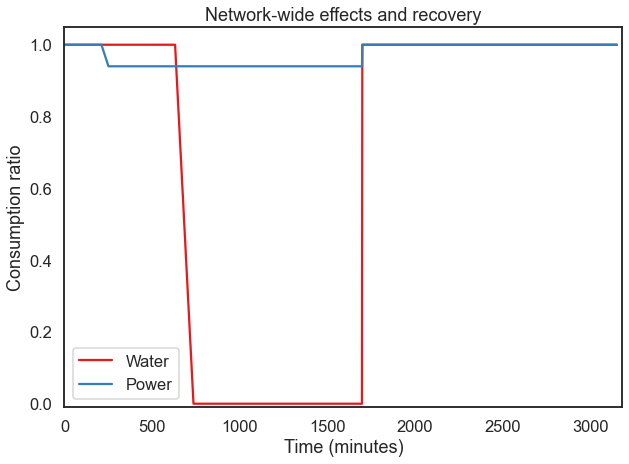

In [55]:
time_tracker, power_consump_tracker, water_consump_tracker = bf_optimizer.get_trackers()
model_plots.plot_interdependent_effects(
        power_consump_tracker,
        water_consump_tracker,
        time_tracker,
        scatter=False,
    )

In [40]:
time_tracker, power_consump_tracker, water_consump_tracker = bf_optimizer.get_trackers()

location = MAIN_DIR/"infrarisk/data/disruptive_scenarios/test1"
bf_simulation.write_results(
    time_tracker, power_consump_tracker, water_consump_tracker, location, plotting=False
)

The simulation results successfully saved to ..\dreaminsg_integrated_model\data\disruptive_scenarios\test1
